Dr Oliviero Andreussi, olivieroandreuss@boisestate.edu

Boise State University, Department of Chemistry and Biochemistry

# Fitting and Data Analysis for the Differential Scanning Calorimetry Experiment {-}

## Preliminary Setup {-}

Before we start, let us import the main modules that we will need for this lecture. You may see some new modules in the list below, we will add more details in the right sections.

In [35]:
# @title Notebook Setup { display-mode: "form" }
# Import the main modules used in this worksheet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.signal import medfilt
from scipy.integrate import simps, cumulative_trapezoid
# Load the google drive with your files 
#from google.colab import drive
#drive.mount('/content/drive')
# The following needs to be the path of the folder with all your datafile in .csv format
base_path = '/content/drive/MyDrive/'

In [115]:
# @title Functions to load the data { display-mode: "form" }
def load_data_to_file_dict(file_dict):
    """
    Load a DSC .txt file. 
    The format of the file should have two rows of headers, one extra line of text at the end, and five columns of data
    The columns are: index, time, heat flow, temperature of sample, temperature of reference

    Input variables:
        file_dict : a dictionary with 'path' and 'name' keys corresponding to the file to be loaded
    
    Action: 
        Add to file_dict a Pandas DataFrame with four columns: time (in seconds), heat flow (in W/g), 
        temperature of sample (in C), and temperature of reference (in C)
    """
    data = pd.read_csv(file_dict['path']+file_dict['name'],skiprows=2,skipfooter=1,names=['Time','Heat-Flow','Ts','Tr'],sep=' +',index_col=0,engine='python',encoding='unicode_escape') 
    file_dict['data'] = data
    return

def plot_peak(peak_dict,xaxis='Time'):
    """ 
    """
    if not ('data' in peak_dict): 
        load_data_to_file_dict(peak_dict)
    time_start = peak_dict['time_start']
    time_end = peak_dict['time_end']
    if time_end == 0 : time_end = peak_dict['data'].Time.iat[-1]
    # 
    filtered_data = peak_dict['data'].query(f'Time > {time_start} and Time < {time_end}')
    #
    baseline=medfilt(filtered_data['Heat-Flow'],peak_dict['baseline_width'])
    #
    if xaxis not in peak_dict['data']:
        print("ERROR: Invalid value for xaxis argument")
        return
    elif xaxis == 'Time' :
        plt.xlabel('Time [s]')
    elif xaxis == 'Ts' :
        plt.xlabel('Ts [C]')
    elif xaxis == 'Tr' :
        plt.xlabel('Tr [C]')
    plt.plot(filtered_data[xaxis],filtered_data['Heat-Flow'])
    plt.plot(filtered_data[xaxis],baseline)
    plt.ylabel('Heat Flow [W/g]')
    plt.show()

def plot_peak_list(peak_list,xaxis='Time',key='',value=['']):
    """
    Given a list of dictionary files, plot temperature vs. time for each file into the same plot.
    If key/value are specified, only plot the files for which the key has the specified value.

    Input variables:
        file_list : a list of dictionary files, each with 'path' and 'name' keys corresponding to the file to be loaded
        key: a string with the name of the key to shortlist the files
        value: the value of the key used to select the shortlist of files
    
    Action: 
        Plot temperature vs. time for the selected files  
    """
    if value == '' or key == '':
        peak_shortlist = peak_list
    else :
        peak_shortlist = [f for f in peak_list if f[key] in value ]
    #
    fig, ax = plt.subplots()
    if xaxis == 'Time' :
        plt.xlabel('Time [s]')
    elif xaxis == 'Ts' :
        plt.xlabel('Ts [C]')
    elif xaxis == 'Tr' :
        plt.xlabel('Tr [C]')
    else:
        print("ERROR: unexpected xaxis label")
        return
    #
    for peak in peak_shortlist : 
        if not ('data' in peak): 
            load_data_to_file_dict(peak)
        filtered_data = peak['data'].query(f"Time > {peak['time_start']} and Time < {peak['time_end']}")
        plt.plot(filtered_data[xaxis],filtered_data['Heat-Flow'],label=peak['label'])
    plt.ylabel('Heat-Flow [W/g]')
    plt.legend()
    plt.show()

In [ ]:
def analyze_peak(peak_dict,verbose=False):
    """ 
    """
    if not ('data' in peak_dict): 
        load_data_to_file_dict(peak_dict)
    # Clean signal (filter and baseline)
    time_start = peak_dict['time_start']
    time_end = peak_dict['time_end']
    if time_end == 0 : time_end = peak_dict['data'].Time.iat[-1]
    # 
    filtered_data = peak_dict['data'].query(f'Time > {time_start} and Time < {time_end}').copy()
    #
    baseline=medfilt(filtered_data['Heat-Flow'],peak_dict['baseline_width'])
    filtered_data['Heat-Flow-Clean'] = filtered_data['Heat-Flow'] - baseline
    # Compute the integral
    peak_integral = simps(filtered_data['Heat-Flow-Clean'],filtered_data['Time'])
    peak_dict['integral'] = peak_integral
    if verbose : print(f'The peak integral is {peak_integral:8.6f}')
    # Compute the second derivative of the Heat-Flow wrt Time
    first_derivative = np.gradient(filtered_data['Heat-Flow'], filtered_data['Time'])
    second_derivative = np.gradient(first_derivative, filtered_data['Time'])
    if peak_integral < 0 : 
        # use the minimum value
        transition_index = np.argmax(second_derivative)
    else:
        # use the maximum value
        transition_index = np.argmin(second_derivative)
    transition_temperature = filtered_data.Ts.iat[transition_index]
    peak_dict['T_transition'] = transition_temperature
    if verbose : print(f'The transition temperature is {transition_temperature:6.4f}')

## Visualize the Systems {-}

The following module needs to be installed on Colab. We won't need it too much for this analysis, but they offer a lot of nice features for chemistry programming. 

In [ ]:
# @title Install and load RDKit { display-mode: "form" }
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Draw
!pip install cirpy
import cirpy

In particular we can use them to draw the molecules in our experiments. While for some molecules you can just write their names and RDKit will plot them, for most molecules you will need to provide their SMILES or their CAS numbers. Luckily, CIRpy can usually find SMILES for you, if you type the common name correctly or if you know the CAS number. 

These are the SMILES for the molecules in your DSC experiments:
* paracetamol: 'CC(=O)Nc1ccc(O)cc1'

In [ ]:
# @title Choose the molecule to draw { display-mode: "form" }
input = 'paracetamol' # @param {type:"string"}
input_type = 'name' # @param ["smiles", "name", "cas"] {allow-input: true}
if input_type != 'smiles' :
    smiles=cirpy.resolve( input, 'smiles')
else:
    smiles=input
img = Draw.MolToImage( Chem.MolFromSmiles(smiles), size=(300, 300) )
display(img)

## Loading the Data {-}

We need to load the Google Drive and access an example of a dataset from a kinetics experiment. You can use the same set that I am using by downloading it from Canvas, [here](). Or you can use your own files. I am assuming the file in question will be located in a `Kinetics_Data/` subfolder in your `Colab Notebook/` folder. 

In [ ]:
# @title Set Local Path { display-mode: "form" }
# The following needs to be the path of the folder with all your collected data in .csv format
local_path="Colab Notebooks/DSC_Data/" # @param {type:"string"}
path = base_path+local_path

In [7]:
path = './DSC_Data/'

In order to streamline the fitting of the data, we will be storing the file that corresponds to each experiment into a Python dictionary (`dict`), together with all the relevant information of that experiment and the parameters that we need for the fit. You can use the same statement in the following, but make sure to change the file name from 'indium.txt' (the one that I am using) to the one you want to use.

In [14]:
indium_melting = {'path':path, 'name':'indium.txt', 'label':'In melting', 'time_start': 300, 'time_end': 350, 'baseline_width': 61}
indium_freezing = {'path':path, 'name':'indium.txt', 'label':'In freezing', 'time_start': 0, 'time_end': 0, 'baseline_width': 61}

indium_peaks = [indium_melting, indium_freezing]

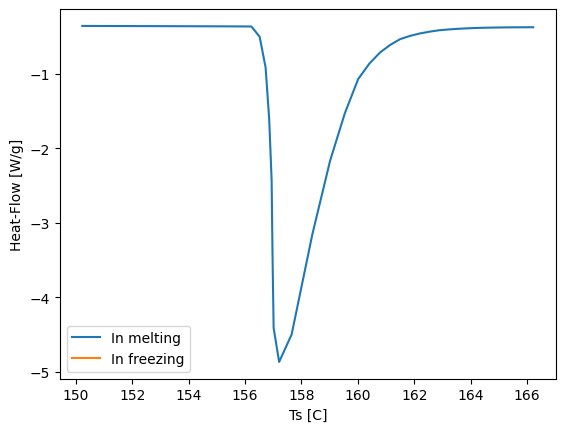

In [15]:
plot_peak_list(indium_peaks,'Ts')

In [13]:
load_data_to_file_dict(indium_melting)

We should always check that the loaded data looks ok, say by checking the number of columns and rows and, maybe, plotting the two columns

In [ ]:
indium_melting['data'].info()

## Adjust the Analysis Parameters {-}

In [ ]:
# @title Find a reasonable time interval around the melting peak { display-mode: "form" }
time_start = 0 # @param {type:"number"}
time_end = 0 # @param {type:"number"}
baseline_width = 61 # @param {type:"integer"}
indium_melting['time_start'] = time_start
indium_melting['time_end'] = time_end
indium_melting['baseline_width'] = baseline_width
plot_peak(indium_melting,xaxis='Time')

In [ ]:
# @title Find the transition temperature and the peak integral { display-mode: "form" }
analyze_peak(indium_melting,verbose=True)

In [166]:
para1 = {'path':path, 'name':'para1.txt', 'label':'In melting', 'time_start': 0, 'time_end': 0, 'baseline_width': 201}
para2 = {'path':path, 'name':'para2.txt', 'label':'In melting', 'time_start': 0, 'time_end': 0, 'baseline_width': 201}


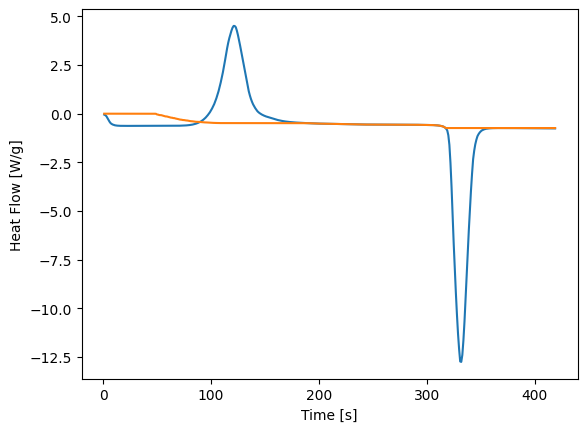

In [167]:
plot_peak(para2)

In [168]:
nylon = {'path':path, 'name':'nylon.txt', 'label':'In melting', 'time_start': 0, 'time_end': 0, 'baseline_width': 201}


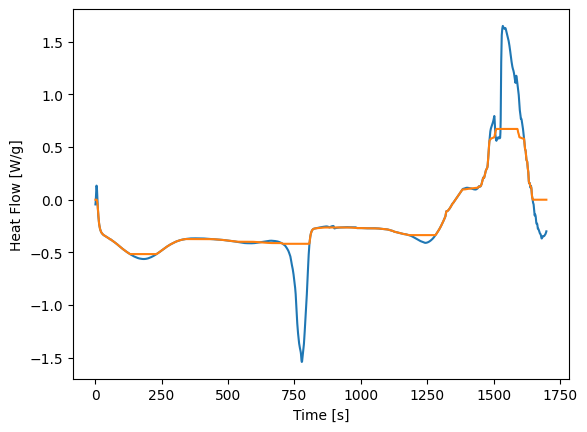

In [169]:
plot_peak(nylon)

In [162]:
cotton = {'path':path, 'name':'cotton.txt', 'label':'In melting', 'time_start': 0, 'time_end': 0, 'baseline_width': 201}


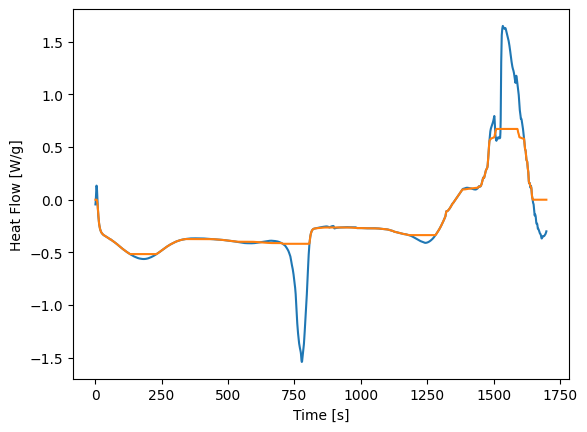

In [163]:
plot_peak(cotton)

In [174]:
peak_dict = cotton

time_start = 650
time_end = 850
if time_end == 0 : time_end = peak_dict['data'].Time.iat[-1]
# 
filtered_data = peak_dict['data'].query(f'Time > {time_start} and Time < {time_end}').copy()

In [175]:
first_derivative = np.gradient(filtered_data['Heat-Flow'], filtered_data['Time'])

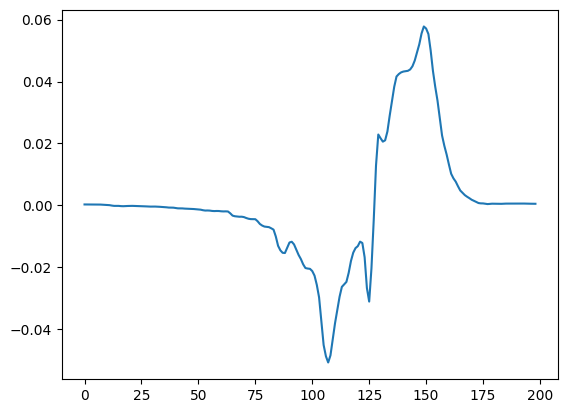

In [176]:
plt.plot(first_derivative)

In [177]:
left_baseline_slope = first_derivative[0]
left_baseline_x0 = filtered_data['Time'].iat[0]
left_baseline_y0 = filtered_data['Heat-Flow'].iat[0]
left_baseline_y = left_baseline_y0 + left_baseline_slope * (filtered_data['Time'] - left_baseline_x0)
#
right_baseline_slope = first_derivative[-1]
right_baseline_x0 = filtered_data['Time'].iat[-1]
right_baseline_y0 = filtered_data['Heat-Flow'].iat[-1]
right_baseline_y = right_baseline_y0 + right_baseline_slope * (filtered_data['Time'] - right_baseline_x0)

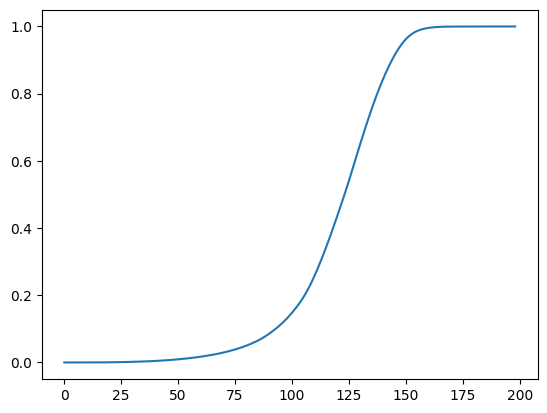

In [178]:
baseline = np.ones(filtered_data['Heat-Flow'].shape)*(left_baseline_y0+right_baseline_y0)*0.5
for i in range(10): 
    gamma = cumulative_trapezoid(filtered_data['Heat-Flow']-baseline,initial=0)/simps(filtered_data['Heat-Flow']-baseline)
    baseline = (1-gamma)*left_baseline_y + gamma*right_baseline_y
plt.plot(gamma)

In [159]:
left_baseline_slope = 0
left_baseline_x0 = filtered_data['Time'].iat[0]
left_baseline_y0 = filtered_data['Heat-Flow'].iat[0]
left_baseline_y = left_baseline_y0 + left_baseline_slope * (filtered_data['Time'] - left_baseline_x0)
#
right_baseline_slope = 0
right_baseline_x0 = filtered_data['Time'].iat[-1]
right_baseline_y0 = filtered_data['Heat-Flow'].iat[-1]
right_baseline_y = right_baseline_y0 + right_baseline_slope * (filtered_data['Time'] - right_baseline_x0)

In [181]:
left_tangent_index = np.argmin(first_derivative)
left_tangent_x0 = filtered_data['Time'].iat[left_tangent_index]
left_tangent_y0 = filtered_data['Heat-Flow'].iat[left_tangent_index]
left_tangent_slope = first_derivative[left_tangent_index]

right_tangent_index = np.argmax(first_derivative)
right_tangent_x0 = filtered_data['Time'].iat[right_tangent_index]
right_tangent_y0 = filtered_data['Heat-Flow'].iat[right_tangent_index]
right_tangent_slope = first_derivative[right_tangent_index]

y = y01 + a1*(x-x01)
y = y02 + a2*(x-x02)
x = (y02-y01 + a1*x01-a2*x02)/(a1-a2) 


In [191]:
onset_x = (left_baseline_y0 - left_tangent_y0 + left_tangent_slope*left_tangent_x0 - left_baseline_slope*left_baseline_x0)/(left_tangent_slope-left_baseline_slope)
onset_y = left_baseline_y0 + left_baseline_slope * (onset_x - left_baseline_x0)

endset_x = (right_baseline_y0 - right_tangent_y0 + right_tangent_slope*right_tangent_x0 - right_baseline_slope*right_baseline_x0)/(right_tangent_slope-right_baseline_slope)
endset_y = right_baseline_y0 + right_baseline_slope * (endset_x - right_baseline_x0)

extrapolated_peak_x = (right_tangent_y0 - left_tangent_y0 + left_tangent_slope*left_tangent_x0 - right_tangent_slope*right_tangent_x0)/(left_tangent_slope-right_tangent_slope)
extrapolated_peak_y = right_tangent_y0 + right_tangent_slope * (extrapolated_peak_x - right_tangent_x0)

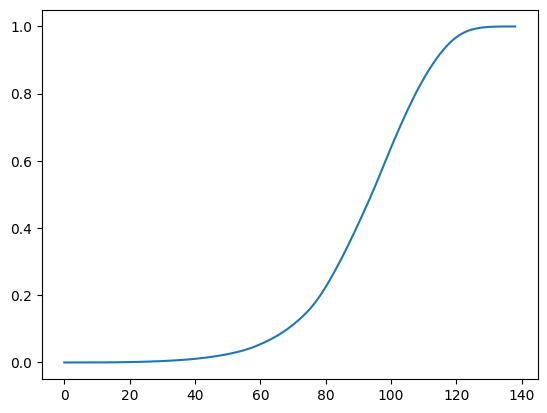

In [172]:
baseline = np.ones(filtered_data['Heat-Flow'].shape)*(left_baseline_y0+right_baseline_y0)*0.5
for i in range(10): 
    gamma = cumulative_trapezoid(filtered_data['Heat-Flow']-baseline,initial=0)/simps(filtered_data['Heat-Flow']-baseline)
    baseline = (1-gamma)*left_baseline_y + gamma*right_baseline_y
plt.plot(gamma)

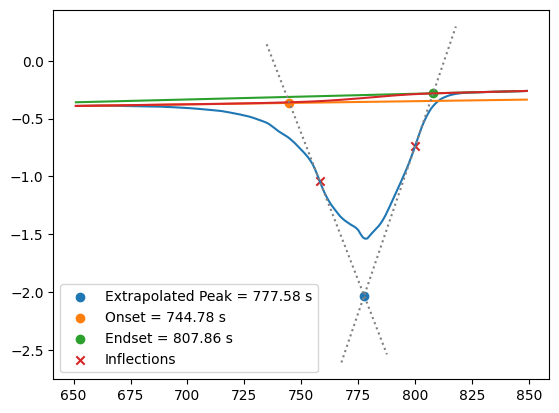

In [206]:
plt.plot(filtered_data['Time'],filtered_data['Heat-Flow'])
plt.plot(filtered_data['Time'],left_baseline_y)
plt.plot(filtered_data['Time'],right_baseline_y)
plt.plot(filtered_data['Time'],baseline)
plt.scatter(extrapolated_peak_x,extrapolated_peak_y,label=f'Extrapolated Peak = {extrapolated_peak_x:6.2f} s')
plt.scatter(onset_x,onset_y,label=f'Onset = {onset_x:6.2f} s')
plt.scatter(endset_x,endset_y,label=f'Endset = {endset_x:6.2f} s')
plt.scatter([left_tangent_x0,right_tangent_x0],[left_tangent_y0,right_tangent_y0],marker='x',label='Inflections')
delta_x = 10
x_tmp = np.linspace(onset_x-delta_x,extrapolated_peak_x+delta_x,10)
y_tmp = left_tangent_y0 + left_tangent_slope * (x_tmp - left_tangent_x0)
plt.plot(x_tmp,y_tmp,':',color='grey')
x_tmp = np.linspace(extrapolated_peak_x-delta_x,endset_x+delta_x,10)
y_tmp = right_tangent_y0 + right_tangent_slope * (x_tmp - right_tangent_x0)
plt.plot(x_tmp,y_tmp,':',color='grey')
plt.legend()